# Modeling

- TODO: add notebook description

## Table of contents:

* [1. Data loading and preprocessing](#first-enumeration)

In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import time
from tqdm.notebook import tqdm



import xgboost as xgb
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly
from prophet.serialize import model_to_json, model_from_json

from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.preprocessing import OneHotEncoder
import holidays

import warnings

warnings.filterwarnings('ignore')

In [2]:
# Global variable for data relative path
DATA_PATH = os.path.abspath("../data/inputs")
RESULTS_PATH = os.path.abspath("../data/outputs")
TRAINED_MODELS_PATH = os.path.abspath("../trained_models")

## 1. Data loading and preprocessing

### 1.1 Data loading

In [3]:
data_train = pd.read_csv(os.path.join(DATA_PATH, "train.csv"))
data_test = pd.read_csv(os.path.join(DATA_PATH, "test.csv"))

### 1.2 Data preprocessing

In [4]:
def is_holiday_week(data):
    #get holiday dates in France from 2012 to 2017
    holidays_france = pd.DataFrame(
        holidays.France(years=range(2012, 2018)).keys(),
        dtype="datetime64[ns]",
        columns=["holiday_date"])

    # make a tuple of (year, week of year)
    holidays_france["year"] = holidays_france["holiday_date"].dt.year
    holidays_france["week"] = holidays_france["holiday_date"].dt.isocalendar().week

    year_week_tuple = list(holidays_france[["year", "week"]].itertuples(index=False, name=None))

    # check each row in the data if it belongs to (year, week of the year) tuple
    return pd.Series(list(zip(data.year, data.week)), index=data.index).isin(year_week_tuple)

In [5]:
def process_dates(data):
    # dates preprocessing
    data["year"] = data.day_id.dt.year
    data["month"] = data.day_id.dt.month
    data["week"] = data.day_id.dt.isocalendar().week
    data["quarter"] = data.day_id.dt.quarter

    # define the 4 seasons of the year based on months
    #seasons = [1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 4, 1]
    #month_to_season = dict(zip(range(1,13), seasons))
    #data["season"] = data.index.month.map(month_to_season)

    #either a day in the weekly turnover belongs to a holiday
    data["is_holiday"] = is_holiday_week(data).astype(int)

    return data

In [6]:
def one_hot_encoding(data, categorical_columns, training=True):
    """add one hot encoding of categorical columns"""

    if training:
        global ohe  # not recommended doing so, but it's the simplest solution
        ohe = OneHotEncoder()
        one_hot_encoded_data = ohe.fit_transform(data[categorical_columns])

    else:
        one_hot_encoded_data = ohe.transform(data[categorical_columns])

    one_hot_df = pd.DataFrame(one_hot_encoded_data.toarray(),
                              columns=ohe.get_feature_names_out(),
                              index=data.index)

    return one_hot_df

In [7]:
def add_turnover_lags(data, time_lag=4):
    """add historical data of the last time_lag year"""

    # add empty columns to fill lags
    for i in range(time_lag):
        lag = np.empty(data.shape[0])
        lag[:] = np.nan
        data["turnover_N-{}".format(i + 1)] = lag

    # get the list of departments and stores
    business_units_list = data.but_num_business_unit.unique()
    department_list = data.dpt_num_department.unique()

    # ingest lags by store and by department
    for i in business_units_list:
        for j in department_list:
            for k in range(1, time_lag + 1):
                lag_data = data.loc[
                    (data.but_num_business_unit == i) & (data.dpt_num_department == j), "turnover"].shift(-52 * k)
                if lag_data.shape != 0:
                    data.loc[lag_data.index, "turnover_N-{}".format(k)] = lag_data

    return data

In [8]:
def process_data(data, categorical_columns, training=True, time_lag=4):
    # set day_id adequate type
    data["day_id"] = pd.to_datetime(data["day_id"], infer_datetime_format=True)

    # sort data by day_id 
    data.sort_values("day_id", ascending=False, inplace=True)

    # process dates
    _ = process_dates(data)

    # add time lags 
    add_turnover_lags(data, time_lag=time_lag)

    # one hot encoding
    one_hot_encoded_data = one_hot_encoding(data, categorical_columns, training)

    # drop old categorical columns
    data.drop(columns=categorical_columns, inplace=True)

    #concat with the one hot encoded ones
    data = pd.concat([data, one_hot_encoded_data], axis=1)

    return data


In [9]:
data_train = process_data(data_train,
                          categorical_columns=["dpt_num_department", "but_num_business_unit", "year", "month", "week",
                                               "quarter"],
                          training=True)

### 1.3 Split train/eval sets


In [10]:
# train on all data except the last month
train_idx = data_train.day_id.dt.date <= datetime(year=2017, month=8, day=31).date()

In [11]:
X = data_train.drop(labels=['turnover', "day_id"], axis=1)
y = data_train['turnover']

In [12]:
X_train, y_train = X.loc[train_idx], y.loc[train_idx]
X_eval, y_eval = X.loc[~train_idx], y.loc[~train_idx]

In [13]:
print("X_train shape: {}, y_train shape: {}".format(X_train.shape, y_train.shape))
print("X_eval shape: {}, y_eval shape: {}".format(X_eval.shape, y_eval.shape))

X_train shape: (271369, 406), y_train shape: (271369,)
X_eval shape: (6350, 406), y_eval shape: (6350,)


## 2. Train a simple regressor (XGBoost)

Since Xgboost deals with missing values, we will not remove these

In [14]:
xgb_reg = xgb.XGBRegressor(n_estimators=200, n_jobs=-1, max_depth=20, verbosity=1, random_state=42)

In [15]:
xgb_reg.fit(X_train.astype(float), y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=20, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=200,
             n_jobs=-1, num_parallel_tree=1, predictor='auto', random_state=42,
             reg_alpha=0, reg_lambda=1, ...)

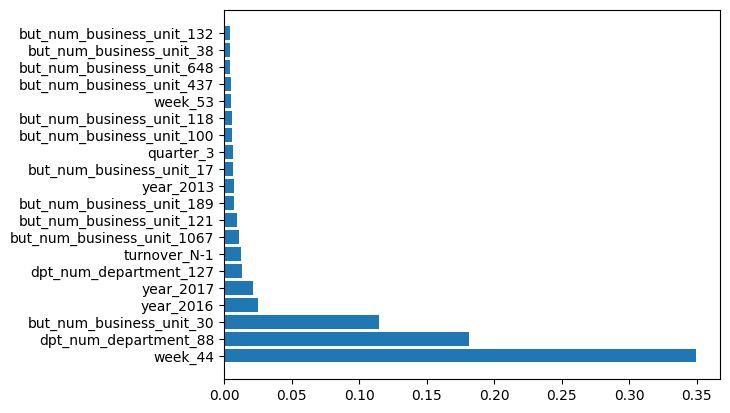

In [16]:
#plot features importance
feature_importances = pd.Series(xgb_reg.feature_importances_, index=X_train.columns).sort_values(ascending=False)
top_20_features = feature_importances[:20]
_ = plt.barh(top_20_features.index, top_20_features)

In [17]:
# save the model 
xgb_reg.save_model(os.path.join(TRAINED_MODELS_PATH, "XGBoost","XGBoost_{}".format(time.strftime("%Y%m%d-%H%M%S"))))

### Evaluate the model

We will use for evaluation MAE and MSE

In [18]:
# get the predictions
y_pred = xgb_reg.predict(X_eval.astype(float))

In [19]:
print("MAE for eval data: {}".format(mean_absolute_error(y_eval, y_pred)))
print("MSE for eval data: {}".format(mean_squared_error(y_eval, y_pred)))

MAE for eval data: 65.23613702152703
MSE for eval data: 14824.242199424454


### Make predictions on the test set

In [20]:
def preprocess_test_data(test_data, historical_data_path):
    """get historical data from data_train"""

    # add an empty turnover column
    empty_column = np.empty(test_data.shape[0])
    empty_column[:] = np.nan
    test_data["turnover"] = empty_column

    historical_data = pd.read_csv(historical_data_path)

    return pd.concat([historical_data, test_data], axis=0, ignore_index=True)

In [21]:
# add lags to data_test from historical data
data_test = preprocess_test_data(data_test, os.path.join(DATA_PATH, "train.csv"))

In [22]:
data_test_copy = data_test[data_test["turnover"].isna()].copy()

In [23]:
#process data_test
data_test = process_data(data_test,
                         categorical_columns=["dpt_num_department", "but_num_business_unit", "year", "month", "week",
                                              "quarter"],
                         training=False)

In [24]:
#drop train data
data_test = data_test[data_test["turnover"].isna()]

In [25]:
#Get X_test data
X_test = data_test.drop(columns=["turnover", "day_id"])

In [26]:
print("X_test shape: {}".format(X_test.shape))

X_test shape: (10136, 406)


In [27]:
#make predictions
y_pred = xgb_reg.predict(X_test.astype(float))

# concat y_pred with X_test
y_pred = pd.DataFrame(y_pred, columns=["turnover_pred"], index=data_test.index)
results = pd.concat([data_test_copy, y_pred], axis=1)
results.head()

,day_id,but_num_business_unit,dpt_num_department,turnover,turnover_pred
277719,2017-11-25,95,73,NaN,-5.315661
277720,2017-11-25,4,117,NaN,1241.183350
277721,2017-11-25,113,127,NaN,798.416138
277722,2017-11-25,93,117,NaN,665.324524
277723,2017-11-25,66,127,NaN,1682.889038


Save results

In [28]:
results.to_csv(os.path.join(RESULTS_PATH, "predictions.csv"))

## 3. Propose another strategy

Our proposed strategy is to make a univariate time-series forecast using an appropriate model for time-series. We chose to use FBProphet for rapid development. We train each model on a tuple of (department, business unit)

### Data loading and preprocessing

In [3]:
data_train = pd.read_csv(os.path.join(DATA_PATH, "train.csv"))
data_test = pd.read_csv(os.path.join(DATA_PATH, "test.csv"))

# set day_id adequate type
data_train["day_id"] = pd.to_datetime(data_train["day_id"], infer_datetime_format=True)
data_test["day_id"] = pd.to_datetime(data_test["day_id"], infer_datetime_format=True)

### Process data for FBProphet

In [4]:
def process_data_prophet(data, num_business_unit, num_department):
    """transform data into FBProphet adequate format"""

    data_prophet = data.loc[:, ['day_id', 'turnover']].rename(columns={"day_id": "ds", 'turnover': 'y'})
    idx_dep_store = (data.but_num_business_unit == num_business_unit) & (data.dpt_num_department == num_department)
    return data_prophet[idx_dep_store]

In [5]:
def get_holidays(years=range(2012, 2024)):
    """Get holidays in France"""

    holiday = pd.DataFrame([])
    for date, name in sorted(holidays.France(years=years).items()):
        holiday = pd.concat([holiday, pd.DataFrame({'ds': date, 'holiday': "FR-Holidays"}, index=[0])],
                            ignore_index=True)
    holiday['ds'] = pd.to_datetime(holiday['ds'], format='%Y-%m-%d', errors='ignore')
    
    return holiday

In [62]:
# get one department and one business unit data and transform data to adequat format for FBProphet 
data_prophet = process_data_prophet(data_train, num_business_unit=64, num_department=127)

#get holidays list in France
holidays_df = get_holidays()

### Train/eval split

In [63]:
def train_eval_split(data, year, month, day):
    # train on all data except the last month
    
    train_idx = data_train.day_id.dt.date <= datetime(year=year, month=month, day=day).date()

    return data[train_idx], data[~train_idx]

In [64]:
prophet_train, prophet_eval = train_eval_split(data_prophet, year=2017, month=8, day=31)
print("Prophet_train shape: {}, Prophet-eval shape: {}".format(prophet_train.shape, prophet_eval.shape))

Prophet_train shape: (244, 2), Prophet-eval shape: (5, 2)


In [65]:
def train_prophet_model(data, holidays_df=None):
    m = Prophet(  #yearly_seasonality=True, #weekly_seasonality=False, #daily_seasonality=False,
        holidays=holidays_df,
        changepoint_prior_scale=0.03,
        n_changepoints=100,
        interval_width=0.9,
    )
    m.fit(data)
    return m

In [66]:
m = train_prophet_model(prophet_train, holidays_df)

00:37:33 - cmdstanpy - INFO - Chain [1] start processing
00:37:33 - cmdstanpy - INFO - Chain [1] done processing


In [67]:
from prophet.serialize import model_to_json, model_from_json

with open('serialized_model.json', 'w') as fout:
    fout.write(model_to_json(m))  # Save model

In [68]:
def make_forecasts(m, periods=10, freq="W", plot_forecasts=True, plot_components=True):
    future = m.make_future_dataframe(periods=periods, freq=freq)
    forecast = m.predict(future)
    if plot_forecasts: plot_plotly(m, forecast).show()
    if plot_components: plot_components_plotly(m, forecast).show()
    return forecast

In [69]:
forecast = make_forecasts(m, plot_forecasts=True, plot_components=True)

In [70]:
def get_yhat(data_eval, forecast):
    """getting predictions from prophet forecasts"""
    
    results = pd.merge(data_eval, forecast, how='inner',
                       left_on=[data_eval.ds.dt.year, data_eval.ds.dt.isocalendar().week],
                       right_on=[forecast.ds.dt.year, forecast.ds.dt.isocalendar().week])
    results.index = data_eval.index
    
    return results

In [71]:
results = get_yhat(prophet_eval, forecast)
results[["ds_x", "yhat_lower", "yhat_upper", "y", "yhat"]]

,ds_x,yhat_lower,yhat_upper,y,yhat
0,2017-09-30,231.654579,1309.026802,580.308443,757.856240
1845,2017-09-23,220.993425,1400.009310,666.932164,801.327197
3200,2017-09-16,221.091426,1304.784395,915.977585,764.938796
4533,2017-09-09,185.520149,1246.283079,814.823360,705.944806
5349,2017-09-02,233.834499,1336.186302,836.789133,770.078452


In [72]:
print("MAE for business unit {}, department {} is: {}".format(
    127,
    64,
    mean_absolute_error(results["y"], results["yhat"]))
     )

MAE for business unit 127, department 64 is: 127.71417092996255


In [73]:
holidays_df = get_holidays()

# get the list of departments and stores
business_units_list = data_train.but_num_business_unit.unique()
department_list = data_train.dpt_num_department.unique()


In [53]:
if not os.path.exists(os.path.join(TRAINED_MODELS_PATH, "FBProphet")): os.makedirs(
    os.path.join(TRAINED_MODELS_PATH, "FBProphet"))

In [ ]:
forecasts = pd.DataFrame()

for business_unit in tqdm(business_units_list):
    for department in department_list:

        data_prophet = process_data_prophet(data_train, business_unit, department)
        if data_prophet.shape[0] != 0:
            prophet_train, prophet_eval = train_eval_split(data_prophet, year=2017, month=8, day=31)

            m = train_prophet_model(prophet_train, holidays_df)

            #save model to local disk
            model_path = os.path.join(TRAINED_MODELS_PATH, "FBProphet", "model_department_{}_business_unit_{}".format(department, business_unit))
            with open(model_path, 'w') as file_out: file_out.write(model_to_json(m))

            bs_dpt_forecast = make_forecasts(m, plot_forecasts=False, plot_components=False)

            results = get_yhat(prophet_eval, bs_dpt_forecast)
            forecasts = pd.concat([forecasts, results], axis=0)


In [ ]:
all_results

In [17]:
mean_absolute_error(all_results["y"], all_results["yhat"])

94.96543629733513

In [19]:
all_results[["ds_x", "y", "yhat"]]

,ds_x,y,yhat
0,2017-09-30,580.308443,746.182339
1845,2017-09-23,666.932164,788.687210
3200,2017-09-16,915.977585,752.304064
4533,2017-09-09,814.823360,694.565179
5349,2017-09-02,836.789133,760.000122
...,...,...,...
1052,2017-09-30,5.231732,39.157374
2301,2017-09-23,7.721912,15.447963
3444,2017-09-16,20.857649,-28.721657
3922,2017-09-09,4.496372,-59.844462


In [ ]:


with open('serialized_model.json', 'r') as fin:
    m = model_from_json(fin.read())  # Load model